In [96]:
import numpy as np
from numpy import genfromtxt
from numpy import random
import matplotlib as mpl
import matplotlib.gridspec
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import scipy as sp
import sympy
from scipy.integrate import quad, dblquad, tplquad, simpson
from scipy import interpolate
#! /usr/bin/env python
# import lhapdf
from parton import mkPDF
import mcint
import vegas
import pandas as pd
from tqdm.notebook import tqdm
from scipy.optimize import minimize

## My imports
from WIC_Pheno_Formulae import *

# Import LHE

In [97]:
## Import ##
MC_Events_LHE = []; temp_event = []; x = 0
file = open("MC_Events.mylhe",'r').read().splitlines()
for line in file: 
    particle = line.strip().split()
    ### If we're at the 1st particle, increment x
    if particle[0] == 'PID1': x = x + 1
    ### If we encounter a particle (within the same event), append temp_event
    if len(particle) == 9 and x!=2:  
        temp_event.append(particle)
    ### If we encounter a particle in the next event, append MC_Events_LHE and reset temp_event, x
    if x==2:  
        MC_Events_LHE.append(temp_event)
        temp_event = []
        temp_event.append(particle)
        x = 1

## Convert to Floats ## 
MC_Events_LHE_new = [] 
for event in MC_Events_LHE: 
    temp_event = []
    for particle in event:
        new_particle = list(map(float, particle[1:]))
        temp_event.append( [particle[0]] + new_particle )
    MC_Events_LHE_new.append(temp_event)
MC_Events_LHE = MC_Events_LHE_new

In [98]:
def θ(X):
    x = X[0]; y = X[1]; z = X[2]
    return np.arctan(np.sqrt(x**2 + y**2)/z)
def η(θ):
    return -np.log(np.tan(θ/2))
def φ(X):
    x = X[0]; y = X[1]; z = X[2]
    if x>0          : return np.arctan(y/x)
    if x<0  and y>=0: return np.arctan(y/x) + np.pi
    if x<0  and y <0: return np.arctan(y/x) - np.pi
    if x==0 and y >0: return np.pi/2
    if x==0 and y <0: return -np.pi/2

# Loop for all kinematics

In [99]:
## Extract Kinematics from MC_Events_LHE
multiplicities = []; obs_mult = []; obs_excν_mult = []; obs_excν_energy = []; obs_excν_Ecut1_mult = [];
electrons = []; muons = []; taus = [];
eNeutrinos = []; muNeutrinos = []; tauNeutrinos = []; Neutrinos = [];
jets = []; 
μ1s   = []; μ2s   = []; μ3s   = []; μ4s   = []; μ5s  = []; 
μ1ps  = []; μ2ps  = []; μ3ps  = []; μ4ps  = []; μ5ps = []; 
v1s   = []; v2s   = []; v3s   = []; v4s   = []; v5s  = [];
v1ps  = []; v2ps  = []; v3ps  = []; v4ps  = []; v5ps = [];
d1s = []; d2s = []; d3s = []; d4s = []; d5s = [];
d1ps = []; d2ps = []; d3ps = []; d4ps = []; d5ps = [];
max_ds = []; minFermionE = []; maxFermionE = []; ProdFermionE = []; max_d_ID = [];
Mff2  = []; Mff3  = []; Mff4  = []; Mff5  = [];
Mff2p = []; Mff3p = []; Mff4p = []; Mff5p = [];
θff2  = []; θff3  = []; θff4  = []; θff5  = [];
θffij = [];
ΔR = [];
MET = []; METν = [];
# 
max_fE = [];
#
Total_xMomentum = []; Total_yMomentum = []; Total_zMomentum = []; Total_Energy = [];
Total_InvMass = []; Total_InvMass_prime = []; fermion_energies = []; 
max1_fermion_energies = []; max2_fermion_energies = []; max3_fermion_energies = [];
max4_fermion_energies = []; max5_fermion_energies = []; max6_fermion_energies = [];
max7_fermion_energies = []; max8_fermion_energies = []; max9_fermion_energies = [];
max10_fermion_energies = []; max11_fermion_energies = []; max12_fermion_energies = [];
max13_fermion_energies = []; max14_fermion_energies = [];
def MassVelVer(pIndex, ID, step):
    if p[0] == ID:
        if ID[-1]!='p':
            eval('μ' + str(step) + 's').append(event[pIndex][2])
            eval('v' + str(step) + 's').append(v)
            if p[8] != np.inf:
                eval('d' + str(step) + 's').append(v*event[pIndex][8])
                max_d_temp.append(v*event[pIndex][8])
                max_d_ID_temp.append(ID)
                if step==1: 
                    eval('f' + str(step+1) + 'aEs').append(event[pIndex+2][3])  ## + 2
                    eval('f' + str(step+1) + 'bEs').append(event[pIndex+3][3])  ## + 3
                if step!=1: 
                    eval('f' + str(step+1) + 'aEs').append(event[pIndex+4][3])  ## + 4
                    eval('f' + str(step+1) + 'bEs').append(event[pIndex+5][3])  ## + 5
        if ID[-1]=='p':
            eval('μ' + str(step) + 'ps').append(p[2])
            eval('v' + str(step) + 'ps').append(v)
            if p[8] != np.inf:
                eval('d' + str(step) + 'ps').append(v*p[8])
                max_d_p_temp.append(v*p[8])
                max_d_p_ID_temp.append(ID)
                if step==1: 
                    eval('f' + str(step+1) + 'apEs').append(event[pIndex+2][3])
                    eval('f' + str(step+1) + 'bpEs').append(event[pIndex+3][3])
                if step!=1: 
                    eval('f' + str(step+1) + 'apEs').append(event[pIndex+4][3])
                    eval('f' + str(step+1) + 'bpEs').append(event[pIndex+5][3])
c=3*10**8 # m/s 

## (incrementing the i^th event 'event' ) ##
for i, event in enumerate(MC_Events_LHE):
# for i, event in enumerate(MC_Events_LHE[:10]):
    Px = 0; Py = 0; Pz = 0; E = 0;
    pxMET = []; pyMET = [];
    pxMETν = []; pyMETν = [];
    e_count = 0;   μ_count = 0;   τ_count = 0;
    νe_count = 0;  νμ_count = 0;   ντ_count = 0;
    jet_count = 0; 
    obs_mult_count = 0; obs_excν_mult_count = 0; obs_excν_Ecut1_mult_count = 0;
    momenta = []; momenta_mags = []; pi_dot_n = []; pi_x_n = [];
    fermion_momenta = []; quark_momenta = [];
    max_d_temp = []; max_d_p_temp = [];
    max_d_ID_temp = []; max_d_p_ID_temp = [];
    f2aEs = [];  f3aEs = [];  f4aEs = [];  f5aEs = [];  f6aEs = [];
    f2apEs = []; f3apEs = []; f4apEs = []; f5apEs = []; f6apEs = []; 
    f2bEs = [];  f3bEs = [];  f4bEs = [];  f5bEs = [];  f6bEs = []; 
    f2bpEs = []; f3bpEs = []; f4bpEs = []; f5bpEs = []; f6bpEs = []; 
    ######################## Multiplicities  ########################
    multiplicities.append(len(event))
    #################################################################
    ## (incrementing the i^th particle 'p' ) ##
    for i, p in enumerate(event): 
        v=c*np.sqrt(p[4]**2 + p[5]**2 + p[6]**2)/p[3]
        ######################## Mass & Velocity & Dis. Vertex & Fermion E ######################## 
        MassVelVer(i, 'PID1', 1)
        MassVelVer(i, 'PID1p', 1)
        MassVelVer(i, 'PID2', 2)
        MassVelVer(i, 'PID2p', 2)
        MassVelVer(i, 'PID3', 3)
        MassVelVer(i, 'PID3p', 3)
        MassVelVer(i, 'PID4', 4)
        MassVelVer(i, 'PID4p', 4)
        MassVelVer(i, 'PID5', 5)
        MassVelVer(i, 'PID5p', 5)
        ###################################################################
        energy_cut = 1 ; 
        ##################### No. e's, mu's, jets, etc ####################
        if np.abs(p[1]) == 11 and p[3] > energy_cut: e_count += 1
        if np.abs(p[1]) == 13 and p[3] > energy_cut: μ_count += 1
        if np.abs(p[1]) == 15 and p[3] > energy_cut: τ_count += 1
        if np.abs(p[1]) == 12: νe_count += 1
        if np.abs(p[1]) == 14: νμ_count += 1
        if np.abs(p[1]) == 16: ντ_count += 1 
        if 1 <= np.abs(p[1]) <= 5 and p[3] > energy_cut: jet_count += 1
        ########## No. Observable Particles, Fermion Momenta & Energies ##########
        if p[1] != 1000000: 
            obs_mult_count += 1
            fermion_momenta.append([p[3],p[4],p[5],p[6]])
            fermion_energies.append(p[3])
            ## excluding ν
            if np.abs(p[1]) != 12 and np.abs(p[1]) != 14 and np.abs(p[1]) != 16: 
                obs_excν_mult_count += 1
                obs_excν_energy.append(p[3])
                if p[3] > energy_cut: obs_excν_Ecut1_mult_count +=1
        ##################### Ferimon Pair Inv Mass, Angles ########################
        if p[0][-1]=='a' or p[0][-2]=='a' :    ## if it's the first fermion in the pair
            fa=event[i][1:]; fb=event[i+1][1:]
            paDOTpb = fa[3]*fb[3] + fa[4]*fb[4] + fa[5]*fb[5]
            pa_mag = np.sqrt(fa[3]**2 + fa[4]**2 + fa[5]**2)
            pb_mag = np.sqrt(fb[3]**2 + fb[4]**2 + fb[5]**2)
        if p[0] == 'PID2a' :
            Mff2.append( np.sqrt(2*(fa[2]*fb[2] - paDOTpb)) )  
            θff2.append(paDOTpb / (pa_mag*pb_mag))
            if 1 <= np.abs(p[1]) <= 5: 
                quark_momenta.append([fa[3],fa[4],fa[5]])
                quark_momenta.append([fb[3],fb[4],fb[5]])
        if p[0] == 'PID3a' : 
            Mff3.append( np.sqrt(2*(fa[2]*fb[2] - paDOTpb)) ) 
            θff3.append(paDOTpb / (pa_mag*pb_mag))
            if 1 <= np.abs(p[1]) <= 5: 
                quark_momenta.append([fa[3],fa[4],fa[5]])
                quark_momenta.append([fb[3],fb[4],fb[5]])
        if p[0] == 'PID4a' :
            Mff4.append( np.sqrt(2*(fa[2]*fb[2] - paDOTpb)) ) 
            θff4.append(paDOTpb / (pa_mag*pb_mag))
            if 1 <= np.abs(p[1]) <= 5: 
                quark_momenta.append([fa[3],fa[4],fa[5]])
                quark_momenta.append([fb[3],fb[4],fb[5]])
        if p[0] == 'PID5a' :
            Mff5.append( np.sqrt(2*(fa[2]*fb[2] - fa[3]*fb[3] - fa[4]*fb[4] - fa[5]*fb[5])) ) 
            if 1 <= np.abs(p[1]) <= 5: 
                quark_momenta.append([fa[3],fa[4],fa[5]])
                quark_momenta.append([fb[3],fb[4],fb[5]])
        if p[0] == 'PID2ap' :
            Mff2p.append( np.sqrt(2*(fa[2]*fb[2] - fa[3]*fb[3] - fa[4]*fb[4] - fa[5]*fb[5])) ) 
        if p[0] == 'PID3ap' : 
            Mff3p.append( np.sqrt(2*(fa[2]*fb[2] - fa[3]*fb[3] - fa[4]*fb[4] - fa[5]*fb[5])) )
        if p[0] == 'PID4ap' : 
            Mff4p.append( np.sqrt(2*(fa[2]*fb[2] - fa[3]*fb[3] - fa[4]*fb[4] - fa[5]*fb[5])) ) 
        if p[0] == 'PID5ap' : 
            Mff5p.append( np.sqrt(2*(fa[2]*fb[2] - fa[3]*fb[3] - fa[4]*fb[4] - fa[5]*fb[5])) ) 
        ################################## MET ###########################################
        if p[1] == 1000000 and p[7] == 0:
            pxMET.append(p[4])
            pyMET.append(p[5])
        if (p[1] == 1000000 and p[7] == 0) or\
            np.abs(p[1]) == 12 or np.abs(p[1]) == 14 or np.abs(p[1]) == 16:
            pxMETν.append(p[4])
            pyMETν.append(p[5])
        #################### Check Momentum & Energy Conservation ########################
        if p[7] == 0: 
            Px = Px + p[4]; Py = Py + p[5]; Pz = Pz + p[6]; E  = E  + p[3]
##############################################################################################################
##################### Max Displaced Vertex & Corresponding (min) Fermion Energy  ##########################
    if len(max_d_temp)>0 or len(max_d_p_temp)>0: 
        max_d = 0 
        max_d_p = 0 
        if   len(max_d_temp)>0:  max_d = np.max(max_d_temp)
        if len(max_d_p_temp)>0:  max_d_p = np.max(max_d_p_temp)
        if max_d > max_d_p:
            max_ds.append(max_d)
            d_max_index = np.where(max_d_temp==max_d)[0][0]
            fermionpairWmaxD = [eval('f' + str(d_max_index+2) + 'aEs'), eval('f' + str(d_max_index+2) + 'bEs')]
            max_d_ID.append(max_d_ID_temp[d_max_index])
        if max_d < max_d_p:
            max_ds.append(max_d_p)
            d_max_index = np.where(max_d_p_temp==max_d_p)[0][0]
            fermionpairWmaxD = [eval('f' + str(d_max_index+2) + 'apEs'), eval('f' + str(d_max_index+2) + 'bpEs')]
            max_d_ID.append(max_d_p_ID_temp[d_max_index])
        minFermionE.append(np.min(fermionpairWmaxD))
        maxFermionE.append(np.max(fermionpairWmaxD))
        ProdFermionE.append(np.min(fermionpairWmaxD)*np.max(fermionpairWmaxD))
##################### No. e's, mu's, jets, etc ###########################
    electrons.append(e_count)
    muons.append(μ_count)
    taus.append(τ_count)
    Neutrinos.append(νe_count + νμ_count + ντ_count)
#     muNeutrinos.append(νμ_count)
#     tauNeutrinos.append(ντ_count)
    jets.append(jet_count)
    obs_mult.append(obs_mult_count)
    obs_excν_mult.append(obs_excν_mult_count)
    obs_excν_Ecut1_mult.append(obs_excν_Ecut1_mult_count)
################################### MET ##################################
    MET.append(np.sqrt(sum(pxMET)**2 + sum(pyMET)**2))
    METν.append(np.sqrt(sum(pxMETν)**2 + sum(pyMETν)**2))
######################### Max Fermion Energies ###########################
    if len(fermion_momenta) > 1:
        max1_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-1])
        max2_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-2])
    if len(fermion_momenta) > 2:
        max3_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-3])
    if len(fermion_momenta) > 3:
        max4_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-4])
    if len(fermion_momenta) > 4:
        max5_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-5])
    if len(fermion_momenta) > 5:
        max6_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-6])
    if len(fermion_momenta) > 6:
        max7_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-7])
    if len(fermion_momenta) > 7:
        max8_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-8])
    if len(fermion_momenta) > 8:
        max9_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-9])
    if len(fermion_momenta) > 9:
        max10_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-10])
    if len(fermion_momenta) > 10:
        max11_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-11])
    if len(fermion_momenta) > 11:
        max12_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-12])
    if len(fermion_momenta) > 12:
        max13_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-13])
    if len(fermion_momenta) > 13:
        max14_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-14])
##################### Angles Between Fermion Pairs #######################
    for m, fp1 in enumerate(fermion_momenta):
        for n, fp2 in enumerate(fermion_momenta):
            if m > n: 
                θffij.append((fp1[1]*fp2[1] + fp1[2]*fp2[2] + fp1[3]*fp2[3]) /\
                             (np.sqrt(fp1[1]**2 + fp1[2]**2 + fp1[3]**2)*\
                              np.sqrt(fp2[1]**2 + fp2[2]**2 + fp2[3]**2)))
############################ ΔR of quarks ################################
    for m, qp1 in enumerate(quark_momenta):
        for n, qp2 in enumerate(quark_momenta):
            if m < n: 
                ΔR.append(np.sqrt( (η(θ(qp1)) - η(θ(qp2)))**2 + (φ(qp1) - φ(qp2))**2) )
##################### Momentum Conservation check ########################
    Total_xMomentum.append(Px)
    Total_yMomentum.append(Py)
    Total_zMomentum.append(Pz)
    Total_Energy.append(E)
    ########################  Inv Mass of Entire Event  ######################## 
    Es = []; pxs = []; pys = []; pzs = []
    Eps = []; ppxs = []; ppys = []; ppzs = []
    p = 0
    while True:
        particle = event[p]
        if particle[0] == 'PID1p': break
        p = p + 1
        if particle[7] == 0: 
            Es.append(particle[3])
            pxs.append(particle[4])
            pys.append(particle[5])
            pzs.append(particle[6])
    Total_InvMass.append(np.sqrt(sum(Es)**2 - sum(pxs)**2 - sum(pys)**2 - sum(pzs)**2))
    for k in range(p, len(event)):
        if event[k][7] == 0:
            Eps.append(event[k][3])
            ppxs.append(event[k][4])
            ppys.append(event[k][5])
            ppzs.append(event[k][6])
    Total_InvMass_prime.append(np.sqrt(sum(Eps)**2 - sum(ppxs)**2 - sum(ppys)**2 - sum(ppzs)**2))
    ################################################################################################
print('done!')

/var/folders/3b/1lt3qrpn635524qxcctqlg040000gn/T/ipykernel_65337/2905072860.py:5: RuntimeWarning: invalid value encountered in log
  return -np.log(np.tan(θ/2))


done!


# Loop for C-parameter, Thrust, Spherocity

In [100]:
C = []; Thrust = []; Spherocity = []
for i, event in enumerate(MC_Events_LHE):
    if i%5000==0: print(str(i) + ' of ' + str(len(MC_Events_LHE)))
    #################################################################################
    momenta = []; momenta_mags = []; pi_dot_n = []; pi_x_n = [];
    ###################### C-Parameter, Thrust, Spherocity ###########################
    for i, p in enumerate(event): 
        if p[7] == 0:
            momenta.append([p[4], p[5], p[6]])
            momenta_mags.append(np.sqrt(p[4]**2 + p[5]**2 + p[6]**2))
            angles = 'placeholder'
            def n(θ,φ): return [np.sin(θ)*np.cos(φ),np.sin(θ)*np.sin(φ),np.cos(θ)] 
            def p_dot_n_func(angles,p): 
                return lambda angles: np.abs(np.dot([p[4], p[5], p[6]], n(angles[0],angles[1])))
            def p_x_n_func(angles,p):
                return lambda angles: np.sqrt(np.cross([p[4], p[5], p[6]], n(angles[0],angles[1]))[0]**2 +\
                                              np.cross([p[4], p[5], p[6]], n(angles[0],angles[1]))[1]**2 +\
                                              np.cross([p[4], p[5], p[6]], n(angles[0],angles[1]))[2]**2)
            pi_dot_n.append(p_dot_n_func(angles,p))
            pi_x_n.append(p_x_n_func(angles,p))
    ###################################################################################     
    c1 = np.outer(momenta_mags, momenta_mags)
    c2 = np.matmul(momenta, np.array(momenta).transpose())
    C.append( (3/2)*np.sum(c1 - (c2**2)/c1)/(np.sum(momenta_mags)**2) )
    max_index = momenta_mags.index(max(momenta_mags))
    max_momenta = momenta[max_index]
    θ_guess = θ(max_momenta)
    φ_guess = φ(max_momenta)
    pi_dot_n = np.array(pi_dot_n)
    def sum_pi_dot_n(angles):
        return -np.sum(np.array([pni(angles) for pni in pi_dot_n]))/np.sum(momenta_mags)
    def sum_pi_x_n(angles):
        return ((4/np.pi)*(np.sum(np.array([pni(angles) for pni in pi_x_n]))/np.sum(momenta_mags)))**2
    b = ((0,np.pi),(0,2*np.pi))
    max_sum_pi_dot_n = minimize(sum_pi_dot_n, (θ_guess,φ_guess),
                                 method='COBYLA', bounds=b)
    min_sum_pi_x_n = minimize(sum_pi_x_n, (θ_guess,φ_guess),
                                 method='COBYLA', bounds=b)
#     print(max_sum_pi_dot_n.x, min_sum_pi_x_n.x)
    Thrust.append(-max_sum_pi_dot_n.fun)
    Spherocity.append(min_sum_pi_x_n.fun)

0 of 875


/Users/stevenferrante/Library/Python/3.8/lib/python/site-packages/scipy/optimize/_minimize.py:544: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


# C-Parameter, Thrust, Spherocity

Text(0.5, 0, 'C-Parameter')

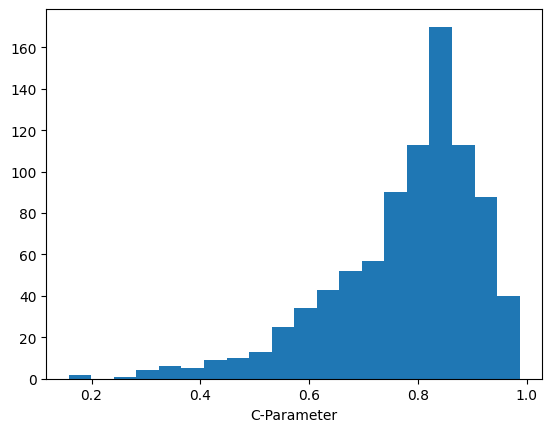

In [101]:
plt.hist(C,bins=20);
plt.xlabel("C-Parameter")

0.4847042486827635 0.9717815631507801


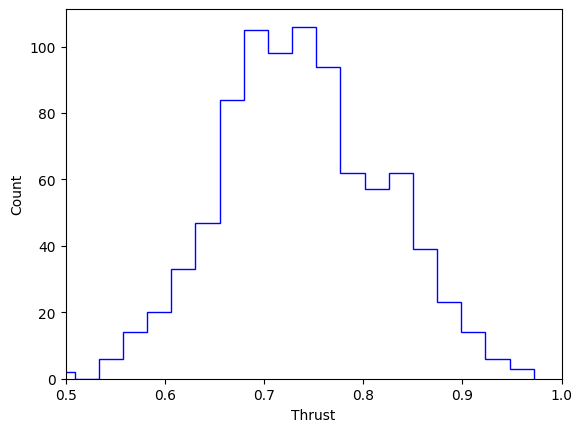

In [102]:
plt.hist(Thrust,bins=20,histtype='step',color='b');
plt.xlabel('Thrust')
plt.ylabel('Count')
print(min(Thrust), max(Thrust))
plt.xlim(0.5,1);

0.050663992350316586 0.8788827243688703


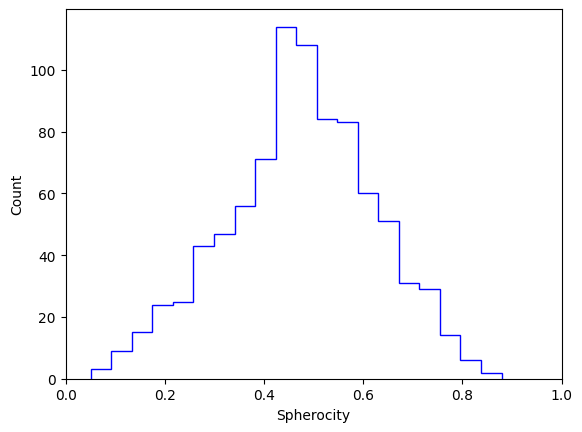

In [103]:
plt.hist(Spherocity,bins=20,histtype='step',color='b');
plt.xlabel("Spherocity");
plt.ylabel('Count')
print(min(Spherocity), max(Spherocity))
plt.xlim(0,1);

# Kinematics

875 874 706 222 16
875 870 701 234 13


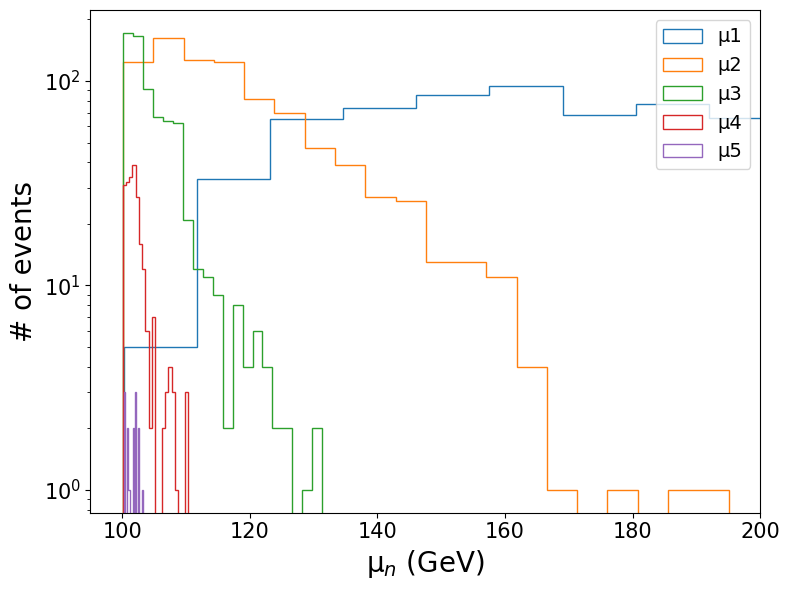

In [104]:
plt.figure(figsize=(8, 6))
nbins=20
plt.hist(μ1s, bins=nbins, histtype='step');
plt.hist(μ2s, bins=nbins, histtype='step');
plt.hist(μ3s, bins=nbins, histtype='step');
plt.hist(μ4s, bins=nbins, histtype='step');
plt.hist(μ5s, bins=nbins, histtype='step');
plt.xlim(95,200)
print(len(μ1s), len(μ2s), len(μ3s), len(μ4s), len(μ5s))
print(len(μ1ps), len(μ2ps), len(μ3ps), len(μ4ps), len(μ5ps))
# plt.hist(μ1ps, bins=nbins, histtype='step', color='k', alpha=0.3);
# plt.hist(μ2ps, bins=nbins, histtype='step', color='k', alpha=0.3);
# plt.hist(μ3ps, bins=nbins, histtype='step', color='k', alpha=0.3);
# plt.hist(μ4ps, bins=nbins, histtype='step', color='k', alpha=0.3);
# plt.hist(μ5ps, bins=nbins, histtype='step', color='k', alpha=0.3);
plt.legend(['μ1', 'μ2','μ3', 'μ4','μ5'], fontsize=14, loc="upper right");
plt.yscale('log')
plt.ylabel('# of events',size=20)
plt.xlabel('μ$_{n}$ (GeV)', size=20)
plt.tick_params(labelsize=15);
plt.tight_layout()

875 874 706 222 16
[0.63590611 0.67531702 0.6697495  0.62995531 0.60954001]
0.6440935887320511


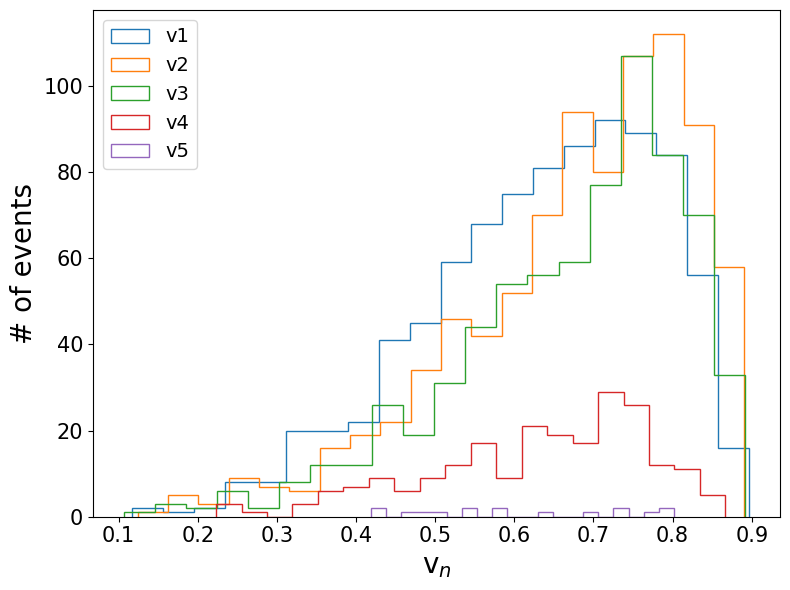

In [105]:
plt.figure(figsize=(8, 6))
nbins=20
v1s = np.array(v1s); v2s = np.array(v2s); v3s = np.array(v3s) 
v4s = np.array(v4s); v5s = np.array(v5s)
plt.hist(v1s/c, bins=nbins, histtype='step');
plt.hist(v2s/c, bins=nbins, histtype='step');
plt.hist(v3s/c, bins=nbins, histtype='step');
plt.hist(v4s/c, bins=nbins, histtype='step');
plt.hist(v5s/c, bins=nbins, histtype='step');
# plt.xlim(95,150)
print(len(v1s), len(v2s), len(v3s), len(v4s), len(v5s))
avg_vs = np.array([v1s.mean()/c, v2s.mean()/c, v3s.mean()/c, v4s.mean()/c, v5s.mean()/c])
print(avg_vs)
print(avg_vs.mean())
# plt.hist(v1ps, bins=nbins, histtype='step', color='k', alpha=0.3);
# plt.hist(v2ps, bins=nbins, histtype='step', color='k', alpha=0.3);
# plt.hist(v3ps, bins=nbins, histtype='step', color='k', alpha=0.3);
# plt.hist(v4ps, bins=nbins, histtype='step', color='k', alpha=0.3);
# plt.hist(v5ps, bins=nbins, histtype='step', color='k', alpha=0.3);
plt.legend(['v1', 'v2', 'v3', 'v4', 'v5'], fontsize=14, loc="upper left");
plt.ylabel('# of events',size=20)
plt.xlabel('v$_{n}$', size=20)
plt.tick_params(labelsize=15);
plt.tight_layout()
# plt.yscale('log')

874 706 222 16


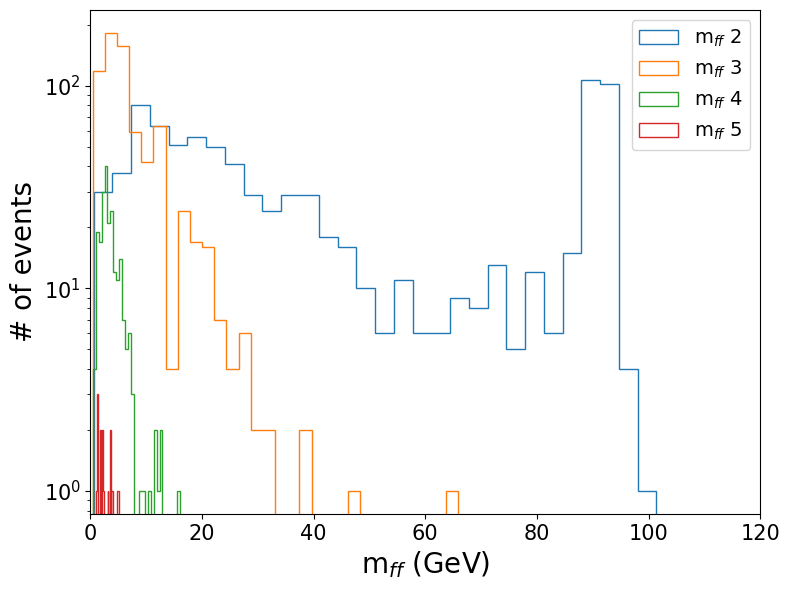

In [106]:
plt.figure(figsize=(8, 6))
print(len(Mff2), len(Mff3), len(Mff4), len(Mff5))
nbins=30
plt.hist(Mff2, bins=nbins, histtype='step', alpha=1);
plt.hist(Mff3, bins=nbins, histtype='step', alpha=1);
plt.hist(Mff4, bins=nbins, histtype='step', alpha=1);
plt.hist(Mff5, bins=nbins, histtype='step', alpha=1);
# plt.hist(Mff2p, bins=nbins, histtype='step', color='gray', alpha=0.3);
# plt.hist(Mff3p, bins=nbins, histtype='step', color='gray', alpha=0.3);
# plt.hist(Mff4p, bins=nbins, histtype='step', color='gray', alpha=0.3);
# plt.hist(Mff5p, bins=nbins, histtype='step', color='gray', alpha=0.3);
plt.legend(['m$_{ff}$ 2', 'm$_{ff}$ 3', 'm$_{ff}$ 4', 'm$_{ff}$ 5'], fontsize=14, loc="upper right");
plt.yscale('log')
plt.ylabel('# of events',size=20)
plt.xlim(0,120)
plt.xlabel('m$_{ff}$ (GeV)', size=20)
plt.tick_params(labelsize=15);
plt.tight_layout()

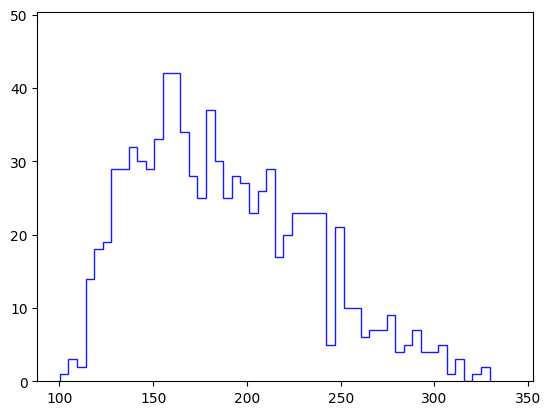

In [107]:
## Total 3-body Invariant Mass (Sanity Check)
plt.hist(Total_InvMass, bins=50, histtype='step', color='blue', alpha=0.9);
plt.hist(Total_InvMass_prime, bins=50, histtype='step', color='gray', alpha=0.);

(0.0, 20.0)

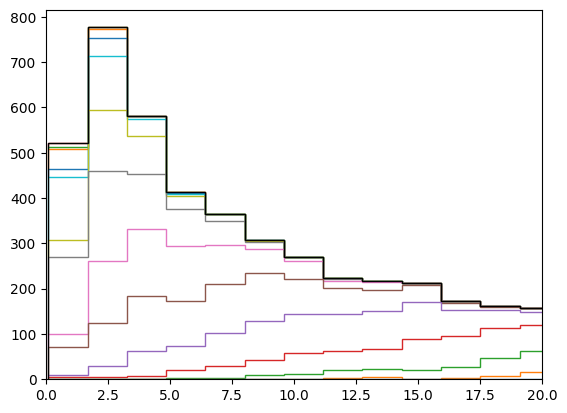

In [108]:
## Fermion Energies (stacked histo)
plt.hist([max1_fermion_energies, max2_fermion_energies, 
          max3_fermion_energies, max4_fermion_energies, 
          max5_fermion_energies, max6_fermion_energies, 
          max7_fermion_energies, max8_fermion_energies,
          max9_fermion_energies, max10_fermion_energies,
          max11_fermion_energies, max12_fermion_energies,
          max13_fermion_energies, max14_fermion_energies], bins=100, histtype='step', stacked=True);
# plt.yscale('log')
plt.hist(fermion_energies, bins=100, histtype='step', color='k')
plt.xlim(0,20)

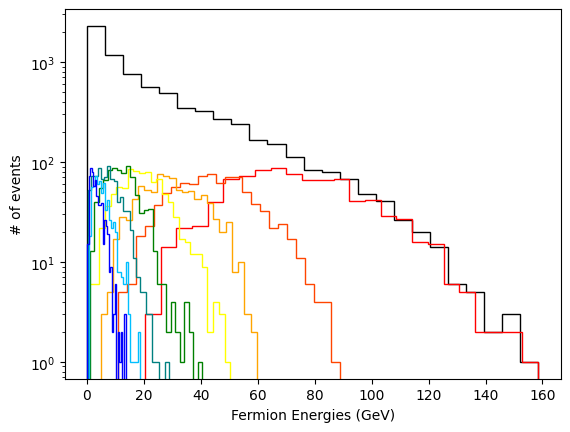

In [109]:
# Fermion Energies
nbins=25
plt.hist(fermion_energies, bins=nbins, histtype='step', color='black');
plt.hist(max1_fermion_energies, bins=nbins, histtype='step', color='red');
plt.hist(max2_fermion_energies, bins=nbins, histtype='step', color='orangered');
plt.hist(max3_fermion_energies, bins=nbins, histtype='step', color='orange');
plt.hist(max4_fermion_energies, bins=nbins, histtype='step', color='yellow');
plt.hist(max5_fermion_energies, bins=nbins, histtype='step', color='green');
plt.hist(max6_fermion_energies, bins=nbins, histtype='step', color='teal');
plt.hist(max7_fermion_energies, bins=nbins, histtype='step', color='deepskyblue');
plt.hist(max8_fermion_energies, bins=nbins, histtype='step', color='blue');
# plt.hist(max9_fermion_energies, bins=200, histtype='step', color='magenta');
# plt.hist(max10_fermion_energies, bins=200, histtype='step', color='indigo');
# plt.hist(max11_fermion_energies, bins=200, histtype='step', color='gray');
plt.xlabel('Fermion Energies (GeV)',size=10)
plt.ylabel('# of events',size=10)
plt.yscale('log')
# plt.legend(['All Fermions', '1st Most Energtic', '2nd Most Energtic', '3rd Most Energtic'],
#            fontsize=10, loc="upper right");
# plt.xscale('log')

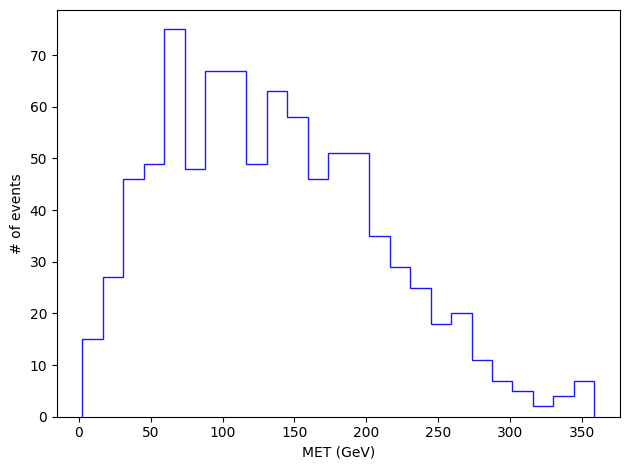

In [110]:
## Missing Energy
plt.hist(METν, bins=25, histtype='step', color='blue', alpha=0.9);
plt.xlabel('MET (GeV)')
plt.ylabel('# of events',size=10)
plt.tight_layout()

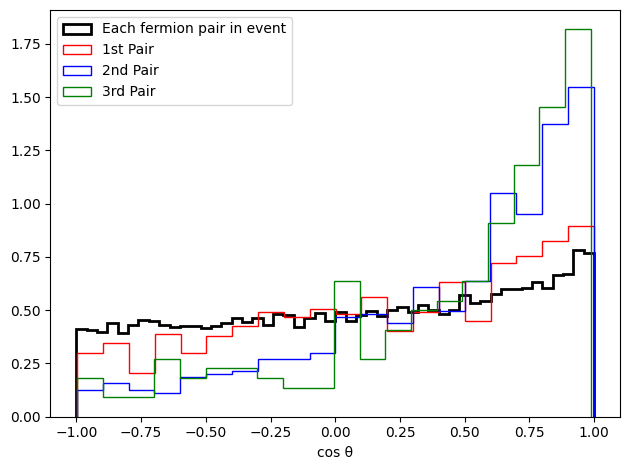

In [111]:
# Angles between all fermion pairs in each event
plt.hist(θffij, bins=50, histtype='step', color='black',density=True, linewidth=2);
# Angle between fermion pairs
plt.hist(θff2, bins=20, histtype='step', color='red',density=True);
plt.hist(θff3, bins=20, histtype='step', color='blue',density=True);
plt.hist(θff4, bins=20, histtype='step', color='green',density=True);
plt.legend(['Each fermion pair in event','1st Pair', '2nd Pair','3rd Pair'],loc='upper left')
plt.xlabel('cos θ')
plt.tight_layout()

Text(0.5, 0, 'ΔR')

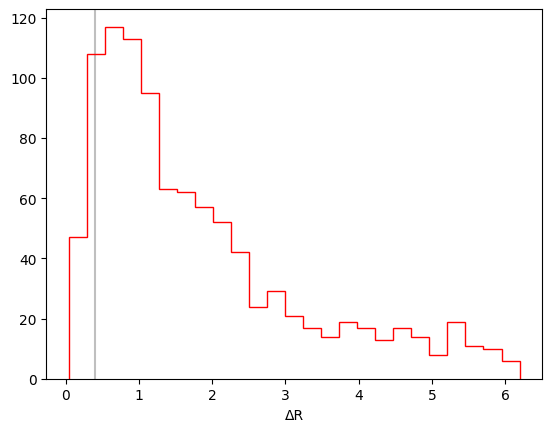

In [112]:
# Delta R
plt.hist(ΔR, bins=25, histtype='step', color='red',density=False);
plt.scatter(0.4,100,marker='|',s=500000, color='gray',alpha=0.5)
plt.xlabel('ΔR')
# plt.yscale('log')

# Multiplicities

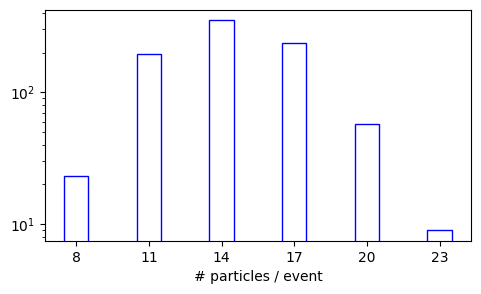

In [113]:
matplotlib.rc_file_defaults()
fig, ax = plt.subplots(1, 1, figsize = (5.5,3))
# Bar Plot
labels, counts = np.unique(multiplicities, return_counts=True)
plt.bar(labels, counts, align='center', width=1, color='white', edgecolor='b')
plt.gca().set_xticks(labels)
plt.xlabel('# particles / event');
plt.yscale('log')

[739  10 118   2   6]
[745   9 114   2   5]
[737   5 125   8]
[739  10 118   2   6]
[745   9 114   2   5]
[737   5 125   0   8]


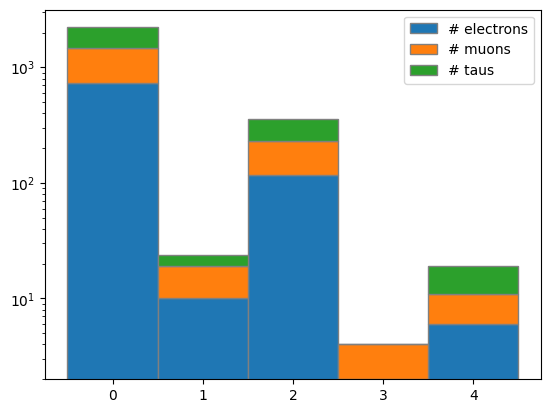

In [130]:
## Electron, Muon, & Tau multiplicities
## (have to adjust 'counts' array if they're not the same length)
labels, tau_counts = np.unique(taus, return_counts=True)
labels, mu_counts = np.unique(muons, return_counts=True)
labels, e_counts = np.unique(electrons, return_counts=True)


print(e_counts)
print(mu_counts)
print(tau_counts)

## need to make arrays the same length
tau_counts = list(tau_counts)
tau_counts.insert(3,0)

print(e_counts)
print(mu_counts)
print(np.array(tau_counts))

fig, ax = plt.subplots()
ax.bar(labels, e_counts, align='center', width=1, edgecolor='gray');
ax.bar(labels, mu_counts, align='center', width=1, edgecolor='gray', bottom=e_counts);
ax.bar(labels, tau_counts, align='center', width=1, edgecolor='gray', bottom=mu_counts+e_counts);

plt.gca().set_xticks(labels);
# (ns, bins, patches) = plt.hist([electrons, muons, taus], bins=4, 
#                                histtype='bar',stacked=True, edgecolor='gray');
ax.legend(['# electrons', '# muons', '# taus'])
plt.yscale('log')

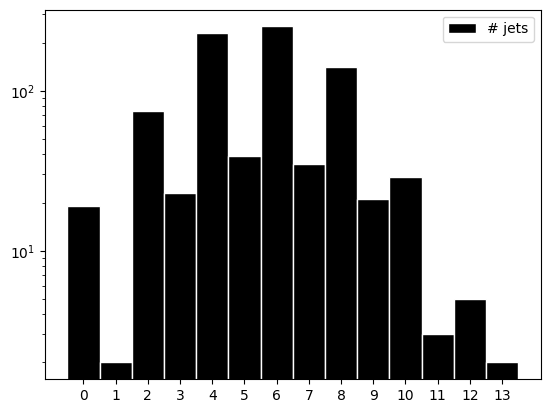

In [131]:
## No. of Jets
labels, counts = np.unique(jets, return_counts=True)
plt.bar(labels, counts, align='center', width=1, edgecolor='white', color='k');
plt.gca().set_xticks(labels);
plt.legend(['# jets'])
plt.yscale('log')

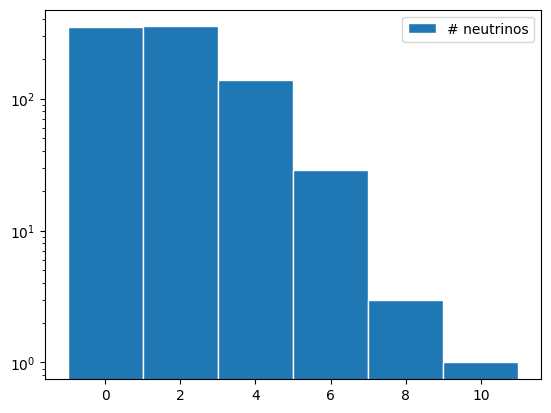

In [132]:
# No. of Neutrinos
labels, nu_counts = np.unique(Neutrinos, return_counts=True)
plt.bar(labels, nu_counts, align='center', width=2, edgecolor='white');
plt.gca().set_xticks(labels);
plt.legend(['# neutrinos'])
plt.yscale('log')

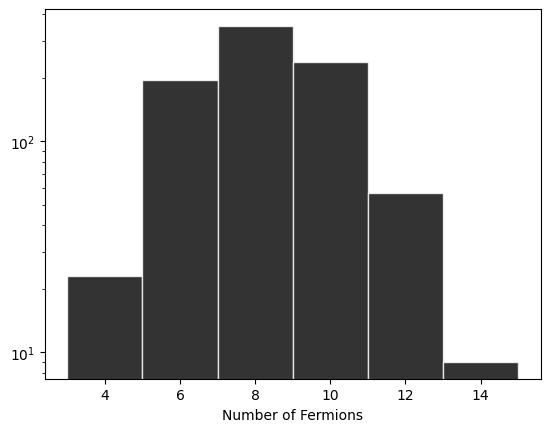

In [133]:
## No. of Fermions
labels, obs_counts = np.unique(obs_mult, return_counts=True)
plt.bar(labels, obs_counts, align='center', width=2, edgecolor='white',color='k',alpha=0.8);
plt.gca().set_xticks(labels);
plt.xlabel('Number of Fermions')
plt.yscale('log')

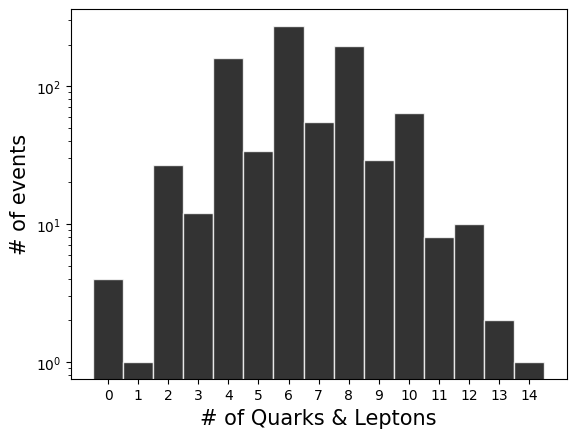

In [134]:
labels, obs_excν_Ecut1_counts = np.unique(obs_excν_Ecut1_mult, return_counts=True)
plt.bar(labels, obs_excν_Ecut1_counts, align='center', width=1, edgecolor='white',color='k',alpha=0.8);
plt.gca().set_xticks(labels);
plt.xlabel('# of Quarks & Leptons',size=15)
plt.ylabel('# of events',size=15)
# plt.legend(['# Fermions'])
plt.yscale('log')